In [1]:
import pandas as pd
df = pd.read_csv('item-demand-time.csv', dtype = object,
                 names=['timestamp','value','client'])
df.head(3)

,timestamp,value,client
0,2014-01-01 01:00:00,38.34991708126038,client_12
1,2014-01-01 02:00:00,33.5820895522388,client_12
2,2014-01-01 03:00:00,34.41127694859037,client_12


/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='timestamp'>

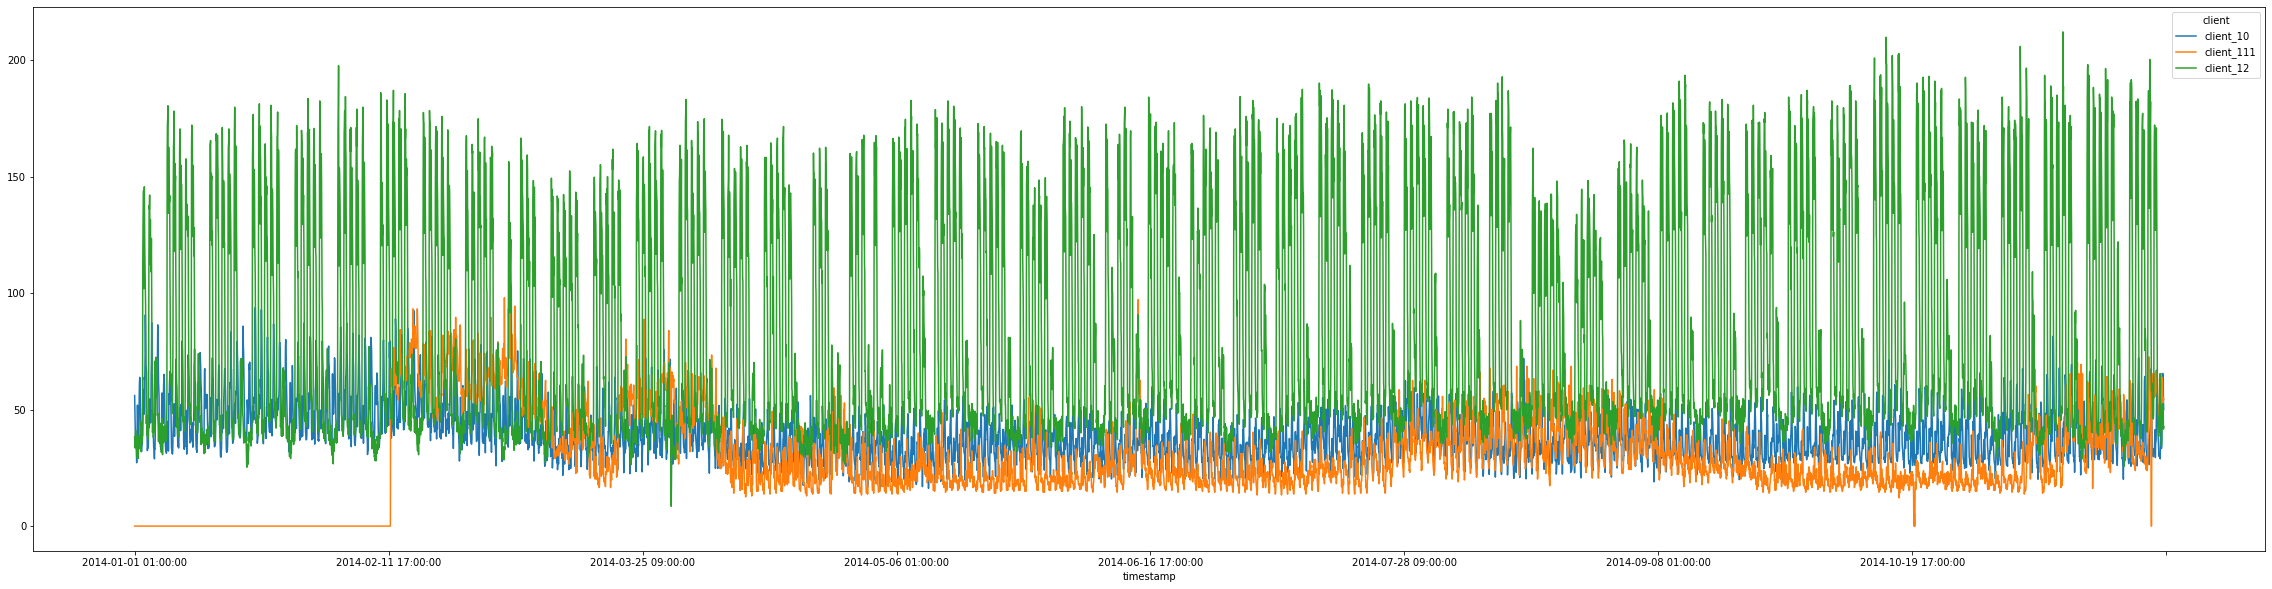

In [3]:
import matplotlib
import matplotlib.pyplot as plt
df.value=pd.to_numeric(df.value)
df_plot=df.pivot(index='timestamp',columns='client',values='value')
df_plot.plot(figsize=(40,10))

In [7]:
df = df[df['client']=='client_12']
df = df.drop(['client', 'timestamp'], axis=1)
df.value *= 100
df.value = df.value.astype('int32')
df.head()

,value
0,3834
1,3358
2,3441
3,3980
4,4104


In [8]:
import boto3
import sagemaker
sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'electricity'
df.to_csv('electricity.csv', index=False, header=False)
training_data_path = sess.upload_data(
    path='electricity.csv',
    key_prefix=prefix + '/input/training')

In [10]:
training_data_channel = sagemaker.TrainingInput(
    s3_data=training_data_path,
    content_type='text/csv;label_size=0',
    distribution='ShardedByS3Key')
rcf_data = {'train': training_data_channel}

In [11]:
from sagemaker.estimator import Estimator
from sagemaker import image_uris
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
container = image_uris.retrieve('randomcutforest', region)

In [12]:
rcf_estimator = Estimator(
    container,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path='s3://{}/{}/output'.format(bucket,prefix))

rcf_estimator.set_hyperparameters(feature_dim=1)
rcf_estimator.fit(rcf_data)

2021-04-07 09:43:28 Starting - Starting the training job...
2021-04-07 09:43:30 Starting - Launching requested ML instancesProfilerReport-1617788608: InProgress
......
2021-04-07 09:44:51 Starting - Preparing the instances for training......
2021-04-07 09:45:50 Downloading - Downloading input data...
2021-04-07 09:46:22 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/07/2021 09:46:36 INFO 140478505326400] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvstore': 'dist_async', '_num_kv_servers': 'auto', '_num_gpus': 'auto', '_tuning_objective_metric': '', '_ftp_port': 8999}
[04/07/2021 09:46:36 INFO 140478505326400] Merging with provided co

In [13]:
endpoint_name = 'rcf-demo'
rcf_predictor = rcf_estimator.deploy(
    endpoint_name=endpoint_name,
    initial_instance_count=1,
    instance_type='ml.t2.medium')

-----------------!

In [15]:
#rcf_predictor.content_type = 'text/csv'
rcf_predictor.serializer = sagemaker.serializers.CSVSerializer()
rcf_predictor.deserializer = sagemaker.deserializers.JSONDeserializer()
values = df['value'].astype('str').tolist()
response = rcf_predictor.predict(values)
print(response)

{'scores': [{'score': 1.0994263591}, {'score': 1.4893841311}, {'score': 1.409809115}, {'score': 1.0139051746}, {'score': 0.9320812796}, {'score': 1.4893841311}, {'score': 1.309830686}, {'score': 1.0994263591}, {'score': 1.6026814079}, {'score': 1.8576558603}, {'score': 1.664080999}, {'score': 1.4278971792}, {'score': 1.051609809}, {'score': 1.4471208193}, {'score': 1.896628488}, {'score': 1.3666173833}, {'score': 1.4278971792}, {'score': 1.5260721891}, {'score': 1.2250901111}, {'score': 1.1575553839}, {'score': 1.0752763814}, {'score': 1.409809115}, {'score': 1.1757704972}, {'score': 1.0364338695}, {'score': 0.8014998535}, {'score': 1.4893841311}, {'score': 1.6433278046}, {'score': 0.9786272152}, {'score': 1.0364338695}, {'score': 1.282483451}, {'score': 0.7831087911}, {'score': 0.8179271877}, {'score': 1.0523467902}, {'score': 0.9233043725}, {'score': 0.9161486513}, {'score': 0.9588956529}, {'score': 0.9830147075}, {'score': 1.1025404703}, {'score': 0.9793354994}, {'score': 0.91650981

In [19]:
from statistics import mean,stdev
import numpy
scores = []
for s in response['scores']:
    scores.append(s['score'])
    score_mean = mean(scores)
    score_std = numpy.std(scores)

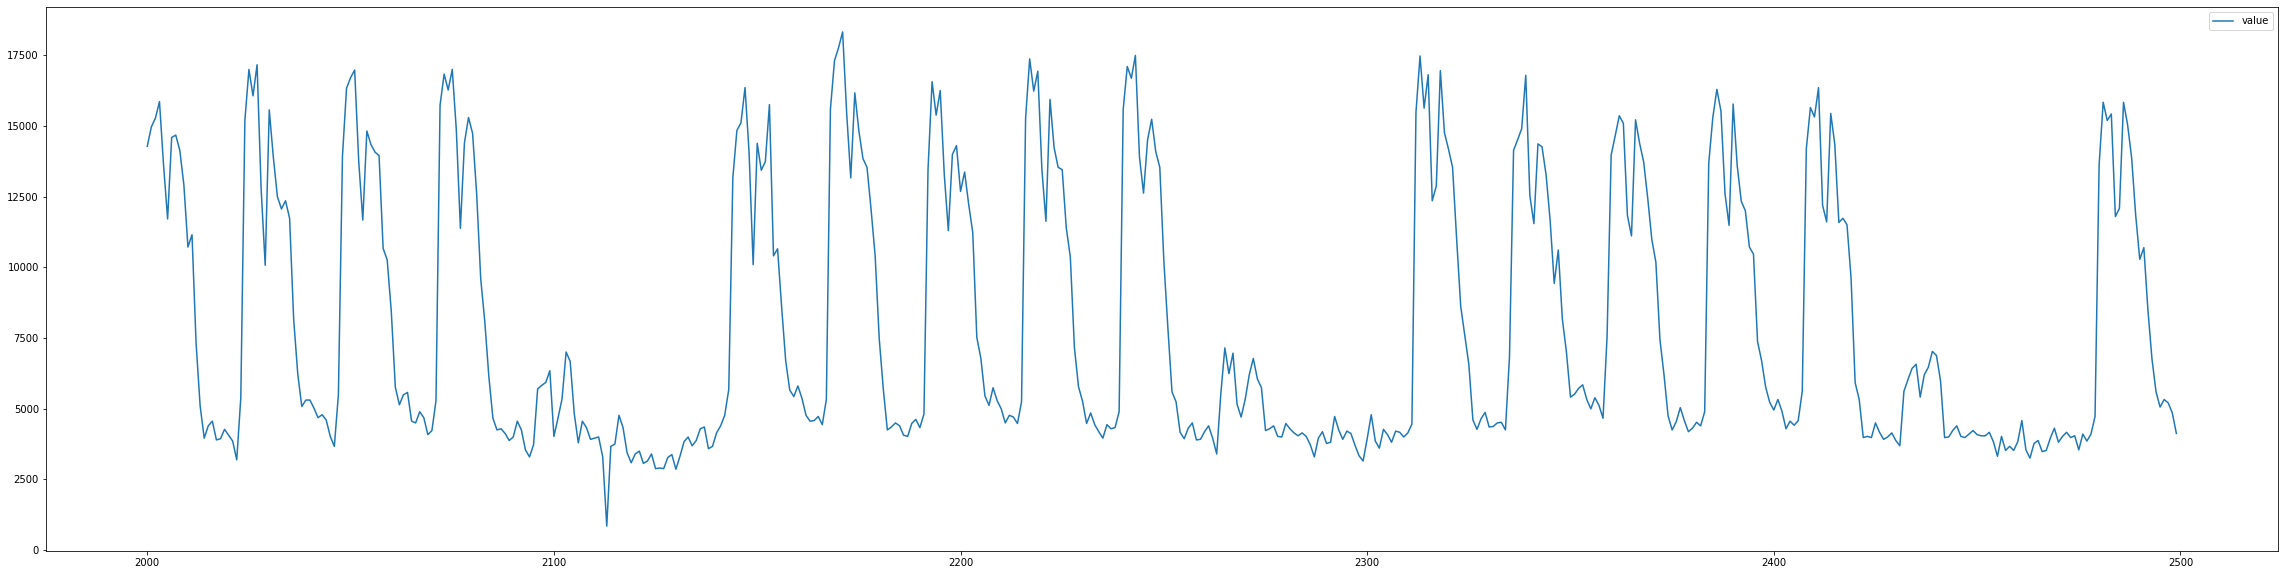

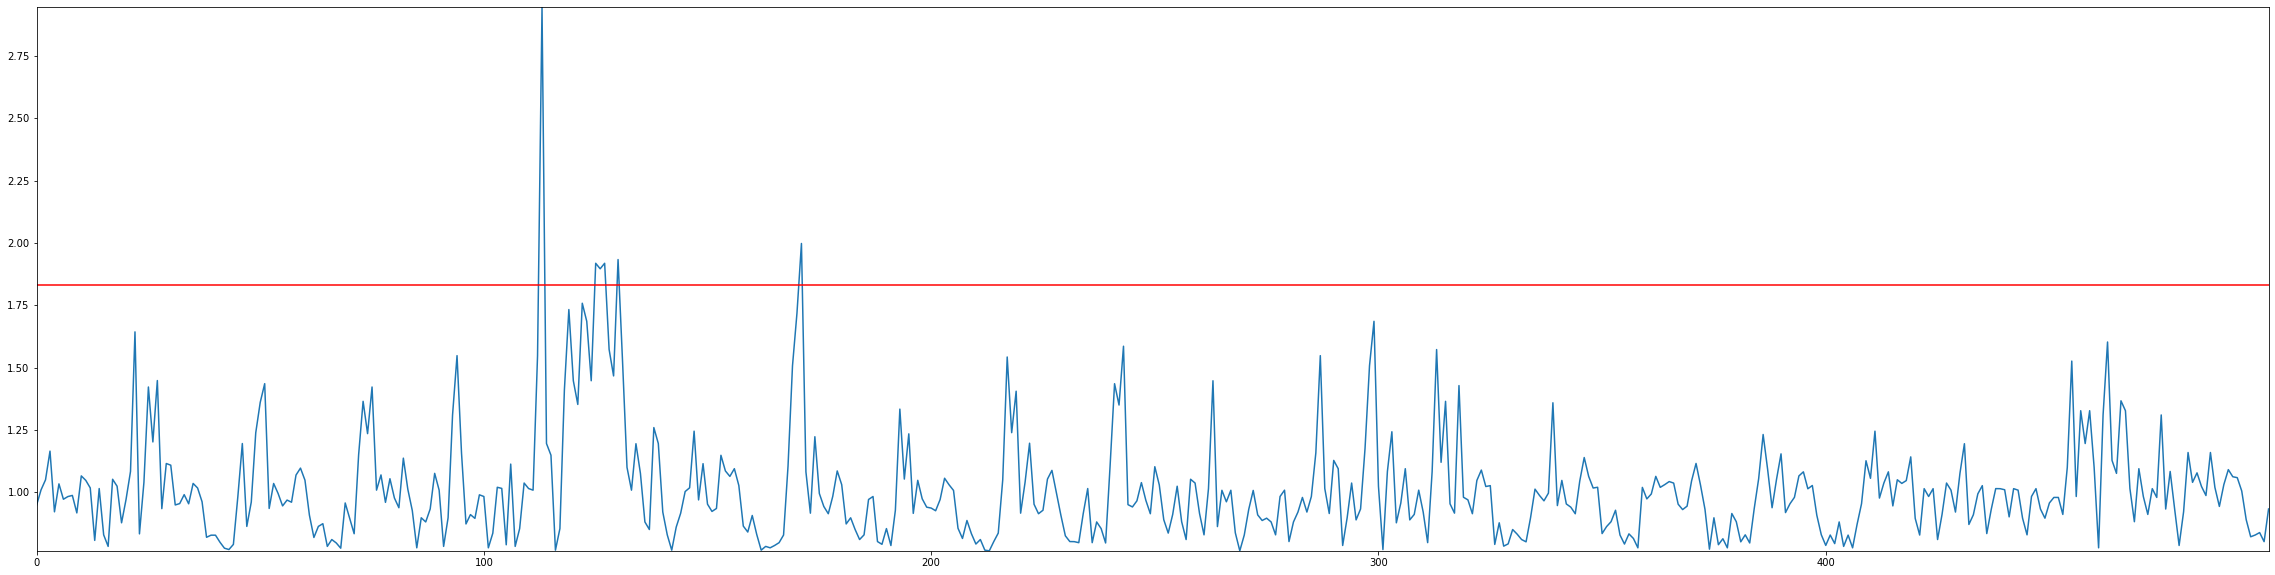

In [20]:
df[2000:2500].plot(figsize=(40,10))
plt.figure(figsize=(40,10))
plt.plot(scores[2000:2500])
plt.autoscale(tight=True)
plt.axhline(y=score_mean+3*score_std, color='red')
plt.show()

In [21]:
rcf_predictor.delete_endpoint()